# scatter_plot
This is an example of all the techniques used in this folder, however all code is explicitly written here rather than using code stored in the smartfin_ride_api_v2 and double_integral_bandpass filters. (this is because we wrote this in a google colab and were too lazy to copy the modules over). We run our analysis on many smartfin rides and compare the results to heights calculated by CDIP buoys recorded during the date and time of each ride. This shows how consistent our methods are in getting a smartfin to act like a substitude buoy

In [1]:
!pip install PeakUtils
!pip install netCDF4

In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt

plt.rc("font", size=14) 

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#from mpl_toolkits.basemap import Basemap

import io
import os
import datetime
import pytz
import re

import peakutils
import statsmodels.api as sm

import requests

import scipy as sp
import random

In [3]:
url = 'https://raw.githubusercontent.com/UCSD-E4E/Smartfin/master/Ben%20Experiments/2017%20Ride%20IDs.csv' #2017 data
#url = 'https://raw.githubusercontent.com/UCSD-E4E/Smartfin/master/Ben%20Experiments/Ride_IDs_2019.csv' #2019 data
Ride_ID = pd.read_csv(url)
#for jupyter notebook
#Ride_ID = pd.read_csv('2017 Ride IDs.csv')
IDs = Ride_ID['Ride Number'].values.tolist()
print(IDs)
len(IDs)

[14796, 13359, 13118, 12988, 12985, 12984, 12983, 12982, 12981, 12980, 12979, 12884, 12863, 12862, 12843, 12833, 12747, 12721, 12705, 12704, 12703, 12702, 12701, 12700, 12699, 12696, 12694, 12693, 12692, 12673, 12533, 12531, 12530, 12502, 12488, 12484, 12477, 12476, 12250, 12187, 12186, 12181, 12180, 12179, 12178, 12177, 12147, 12146, 12140, 12093, 12088, 12086, 12084, 12081, 12027, 12026, 12025, 12024, 12022, 12021, 12020, 12019, 12018, 12008, 11982, 11974, 11947, 11943, 11912, 11907, 11906, 11897, 11896, 11895, 11822, 11821, 11769, 11764, 11763, 11762, 11761, 11760, 11759, 11751, 11750, 11730, 11713, 11709, 11695, 11670, 11663, 11636, 11603, 11552, 11543, 11542, 11538, 11534, 11533, 11528, 11521, 11518, 11516, 11506, 11505, 11502, 11475, 11460, 11442, 11420, 11419, 11416, 11415, 11409, 11398, 11390, 11378, 11219, 11209, 11207, 11176, 11173, 11168, 11167, 11165, 11163, 11161, 11158, 11157, 11151, 11126, 11119, 11051, 11049, 11047, 11045, 11044, 11015, 11009, 11008, 10967, 10922, 10921

153

In [4]:
ride_ids = IDs[0:50]

Webscrape code here

# imports

In [5]:
import pandas as pd
import numpy as np

import os
import datetime
import pytz
import re
import statsmodels.api as sm
import requests
import netCDF4
import datetime
import time
from bs4 import BeautifulSoup
import requests

fin_url_base = 'http://surf.smartfin.org/fin/'
str_id_ride = 'rideId = \'' # backslash allows us to look for single quote
str_id_date = 'var date = \'' # backslash allows us to look for single quote
ride_url_base = 'https://surf.smartfin.org/ride/'
str_id_csv = 'img id="temperatureChart" class="chart" src="' 

# cdip web scrape

In [6]:
def get_timeframe(df):

    # get the times of the first and last reading
    df = df.reset_index()
    df = df.set_index('UTC')
    start_time = pd.to_datetime(df.index[0]).strftime('%d/%m/%Y %H:%M:%S')
    end_time = pd.to_datetime(df.index[-1]).strftime('%d/%m/%Y %H:%M:%S')
    return [start_time, end_time]

# Find nearest value in ncTime array to inputted UNIX Timestamp
def find_nearest(array, value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]


# Convert human-formatted date to UNIX timestamp
def getUnixTimestamp(humanTime, dateFormat):
    unixTimestamp = int(time.mktime(datetime.datetime.strptime(humanTime, dateFormat).timetuple()))
    return unixTimestamp


def CDIP_web_scrape(start_time, end_time):
        
    station = '201'
    data_url = f'http://thredds.cdip.ucsd.edu/thredds/dodsC/cdip/archive/{station}p1/{station}p1_historic.nc'
    print(f'retriving CDIP wave heights from: {data_url}')
    
    # netCDF data object fetched from CDIP API
    nc = netCDF4.Dataset(data_url)

    # UNIX based time from 1991-yeardate in 30 minute increments
    ncTime = nc.variables['waveTime'][:]

    # wave heights
    Hs = nc.variables['waveHs']
    
    # find the 30 minute chunks that correspond with smartfin ride timeframe
    unixstart = getUnixTimestamp(start_time,"%d/%m/%Y %H:%M:%S")
    nearest_date = find_nearest(ncTime, unixstart)  # Find the closest unix timestamp
    start_index = np.where(ncTime==nearest_date)[0][0]  # Grab the index number of found date

    unixend = getUnixTimestamp(end_time,"%d/%m/%Y %H:%M:%S")
    future_date = find_nearest(ncTime, unixend)  # Find the closest unix timestamp
    end_index = np.where(ncTime==future_date)[0][0]  # Grab the index number of found date 
    
    # account for index offsets
    # start_index -= 14
    # end_index -= 14
    
    print(f'calculating significant wave height between {start_time} - {end_time}')
    
    # all wave height averages per 30 minute increments over each month
    ride_hs = Hs[start_index:end_index]
    ride_hs = ride_hs.data
    
    # calculate means of each month dataset in box_data
    mean = ride_hs.mean()
    
    print(f'mean wave height: {mean}')
    
    return mean


# smartfin web scrape

In [7]:
# helper methods 
def get_ride(ride_id, convert_imu=True):
    """
    adds a ride dataframe to this dictionary 

    """


    # get df from ride number
    # get given ride's CSV from its ride ID using function above
    mdf = get_csv_from_ride_id(ride_id) 
    latitude = mdf['Latitude'].mean() / 100000
    longitude = mdf['Longitude'].mean() / 10000
    mdf = mdf.drop(['Latitude', 'Longitude'], axis=1)
    
    #Drop the latitude and longitude values since most of them are Nan:
    # mdf_dropped = mdf.drop(columns=['Latitude', 'Longitude'])
    mdf_dropped = mdf

    #Drop the NAN values from the motion data:
    mdf = mdf_dropped.dropna(axis=0, how='any')
    print('mdf length before time change: ', len(mdf))

    # convert imu data 
    if(convert_imu):

        mdf = mdf.apply(lambda reading: reading / 512 * 9.80665 - 9.80665 
                                                         if reading.name == 'IMU A2'
                                                         else reading)
        mdf = mdf.apply(lambda reading: reading / 512 * 9.80665
                                                         if reading.name == 'IMU A1' or reading.name == 'IMU A3'
                                                         else reading)
        
        # convert time into seconds
        mdf['Time'] = [time / 1000 for time in mdf['Time']] 

        # convert latitude and longitude values
       

        
    timeframe = get_timeframe(mdf)
    print('df length: ', len(mdf))
    print('timeframe: ', timeframe)

    means = CDIP_web_scrape(timeframe[0], timeframe[1])
    


    # add dataframe to dictionary
    return mdf, timeframe, means, latitude, longitude


def get_csv_from_ride_id (ride_id):
    # Build URL for each individual ride
    ride_url = ride_url_base+str(ride_id)
    print(f'fetching ride from: {ride_url}')

    # Get contents of ride_url
    html_contents = requests.get(ride_url).text

    # Find CSV identifier 
    loc_csv_id = html_contents.find(str_id_csv)

    # Different based on whether user logged in with FB or Google
    offset_googleOAuth = [46, 114]
    offset_facebkOAuth = [46, 112]
    if html_contents[loc_csv_id+59] == 'f': # Facebook login
        off0 = offset_facebkOAuth[0]
        off1 = offset_facebkOAuth[1]
    else: # Google login
        off0 = offset_googleOAuth[0]
        off1 = offset_googleOAuth[1]

    csv_id_longstr = html_contents[loc_csv_id+off0:loc_csv_id+off1]

    # Stitch together full URL for CSV
    # other junk URLs can exist and break everything
    if ("media" in csv_id_longstr) & ("Calibration" not in html_contents): 

        url = f'https://surf.smartfin.org/{csv_id_longstr}Motion.CSV'
        print(f'fetching motion data from: {url}')

        # Go to ocean_csv_url and grab contents (theoretically, a CSV)
        df = pd.read_csv(url, parse_dates = [0])

        # Reindex on timestamp if there are at least a few rows
        df = df.set_index('UTC', drop = True, append = False) 

        # resample data at new interval
        sample_interval = '1000ms'
        df = df.resample(sample_interval).mean()
        df['TimeDelta'] = df['Time']-df['Time'][0]
        
        return df

    else:
        print('here')
        df = pd.DataFrame() # empty DF just so something is returned
        return df

## data processing

In [8]:
# remove readings from ocean and motion dataframes where surfer is on land before entering the water
def remove_before_entrance(mdf, odf, threshold, med):
    
    # get temperature series
    temps = odf['Calibrated Temperature 1']
    enter_index = get_water_entrance_index(temps, threshold, med)
    
    # get the time where the surfer enters the water in the ocean dataframe
    startTime = odf.iloc[enter_index]['Time']
    
    # find the index in motion dataframe that matches with start index calculated from ocean dataframe
    startIdx = mdf.iloc[(mdf['Time']-startTime).abs().argsort()[:1]]
    return mdf.loc[startIdx.index[0]:], odf.tail(len(odf) - enter_index)
   

# calculate the index in ocean dataframe that the surfer enters the water
def get_water_entrance_index(temps, threshold, med):

    above = False
    count = 0
    consecutiveWithin = 0
    
    # calculate the index at the point where the temperature readings fall within the threshold consecutively
    for time, reading in temps.items():
        if abs(reading - med) < threshold:
            if above == True:
                above = False
            else:
                consecutiveWithin += 1
                
            # if the temperatures fall within the threshold consecutively, then we can assume the surfer is in the water
            if consecutiveWithin > 10:
                return count

            above = False

        else:
            above = True
            consecutiveWithin = 0
        count += 1 
        
    return firstInstance

# remove readings from ocean and motion dataframes where surfer is on land after exiting the water
def remove_after_exit(mdf, odf, threshold, med):

    # get the temperature series
    temps = odf['Calibrated Temperature 1']
    
    # get the index where surfer exits the water
    exit_index = get_water_exit_index(temps, threshold, med)
    
    # get the time where the surfer enters the water in the ocean dataframe
    endTime = odf.iloc[exit_index]['Time']

    # find the index in motion dataframe that matches with end index calculated from ocean dataframe
    endIdx = mdf.iloc[(mdf['Time']-endTime).abs().argsort()[:1]]
    return mdf.loc[:endIdx.index[0]], odf.head(exit_index)
   
    
# calculate the index in ocean dataframe that the surfer enters the water
def get_water_exit_index(temps, threshold, med):
    above = False
    count = 0

    # calculate the index at the last point where the temperature readings transition from within to outside the threshold 
    for time, reading in temps.items():
        if abs(reading - med) > threshold:
            
            # record index where temperature transition from within to outside the threshold
            if above == False:
                above = True
                firstInstance = count
            
            above = True
        
        else:
            above = False
            firstInstance = 0
        count += 1 
    
    return firstInstance



def get_water_data(mdf, odf):

    temps = odf['Calibrated Temperature 1']
    threshold = temps.std() / 2
    med = temps.median()
    
    mdf, odf = remove_before_entrance(mdf, odf, threshold, med)
    mdf, odf = remove_after_exit(mdf, odf, threshold, med)
    return mdf, odf


In [9]:
dfs = []
times = []
CDIP_means = []
count = 0
for ride_id in IDs:
  if count > 20: break
  count += 1
  try:
    df, timeframe, mean, latitude, longitude = get_ride(ride_id)
    #this cuts off the first 6 minutes
    df = df.head(2160)
    dfs.append(df[360:2160])
    #dfs.append(df.tail(2160))
    #original
    #df = df.head(2300)
    #dfs.append(df.tail(1800))
    times.append(timeframe)
    CDIP_means.append(mean)
  except:
    print("An execption occured")

fetching ride from: https://surf.smartfin.org/ride/14796
fetching motion data from: https://surf.smartfin.org/media/201708/facebook_10103724551106657_0006667E229C_170823155918_Motion.CSV
mdf length before time change:  5938
df length:  5938
timeframe:  ['23/08/2017 15:59:26', '23/08/2017 17:38:23']
retriving CDIP wave heights from: http://thredds.cdip.ucsd.edu/thredds/dodsC/cdip/archive/201p1/201p1_historic.nc
calculating significant wave height between 23/08/2017 15:59:26 - 23/08/2017 17:38:23
mean wave height: 0.6325000524520874
fetching ride from: https://surf.smartfin.org/ride/13359
fetching motion data from: https://surf.smartfin.org/media/201710/google_112035288398314271289_0006667E22BA_171026171300_Motion.CSV
mdf length before time change:  6916
df length:  6916
timeframe:  ['26/10/2017 17:13:09', '26/10/2017 19:08:24']
retriving CDIP wave heights from: http://thredds.cdip.ucsd.edu/thredds/dodsC/cdip/archive/201p1/201p1_historic.nc
calculating significant wave height between 26/

mdf length before time change:  2926
df length:  2926
timeframe:  ['27/12/2017 20:20:27', '27/12/2017 21:09:12']
retriving CDIP wave heights from: http://thredds.cdip.ucsd.edu/thredds/dodsC/cdip/archive/201p1/201p1_historic.nc
calculating significant wave height between 27/12/2017 20:20:27 - 27/12/2017 21:09:12
mean wave height: 0.6200000047683716
fetching ride from: https://surf.smartfin.org/ride/12747
fetching motion data from: https://surf.smartfin.org/media/201712/google_113399247482189200727_000666D32296_171220165703_Motion.CSV
mdf length before time change:  4804
df length:  4804
timeframe:  ['20/12/2017 16:57:13', '20/12/2017 18:17:16']
retriving CDIP wave heights from: http://thredds.cdip.ucsd.edu/thredds/dodsC/cdip/archive/201p1/201p1_historic.nc
calculating significant wave height between 20/12/2017 16:57:13 - 20/12/2017 18:17:16
mean wave height: 0.7300000190734863
fetching ride from: https://surf.smartfin.org/ride/12721
fetching motion data from: https://surf.smartfin.org/m

In [10]:
dfs[0]

,Time,IMU A1,IMU A2,IMU A3,IMU G1,IMU G2,IMU G3,IMU M1,IMU M2,IMU M3,TimeDelta
UTC,,,,,,,,,,,
2017-08-23 16:05:26+00:00,386.332600,-1.900038,-0.344765,0.340934,8.6,12.8,8.80,-23.4,-119.8,349.0,3.583689e+05
2017-08-23 16:05:27+00:00,387.332400,-1.896208,-0.348596,0.329442,8.6,13.0,9.00,-25.4,-117.8,348.6,3.593687e+05
2017-08-23 16:05:28+00:00,388.332000,-1.900038,-0.340934,0.360088,9.2,13.2,8.40,-26.4,-120.4,347.2,3.603683e+05
2017-08-23 16:05:29+00:00,389.252167,-1.900038,-0.344765,0.348596,8.6,12.8,8.20,-25.2,-121.6,351.6,3.612885e+05
2017-08-23 16:05:30+00:00,390.332400,-1.907700,-0.344765,0.356257,8.8,13.0,8.40,-26.0,-124.8,353.2,3.623687e+05
...,...,...,...,...,...,...,...,...,...,...,...
2017-08-23 16:35:21+00:00,2173.902400,3.547249,-0.658884,1.467167,-12.2,52.4,-131.20,-226.0,-40.8,156.0,2.145939e+06
2017-08-23 16:35:22+00:00,2174.853500,2.662352,-0.934696,2.589569,-83.8,38.0,50.20,-199.8,-43.0,116.2,2.146890e+06
2017-08-23 16:35:23+00:00,2175.932400,3.190992,-1.256477,3.045425,60.6,-108.8,35.60,-215.8,-31.8,114.6,2.147969e+06


In [11]:
CDIP_means

[0.63250005,
 0.485,
 0.46,
 0.72,
 0.934,
 0.77750003,
 0.89,
 0.745,
 0.765,
 0.6333333,
 1.12,
 0.485,
 0.39,
 0.45499998,
 0.635,
 0.62,
 0.73,
 0.61,
 0.57,
 0.50333333,
 0.8433333]

In [12]:
times

[['23/08/2017 15:59:26', '23/08/2017 17:38:23'],
 ['26/10/2017 17:13:09', '26/10/2017 19:08:24'],
 ['26/10/2017 19:06:27', '26/10/2017 20:03:01'],
 ['15/12/2017 17:41:08', '15/12/2017 18:55:59'],
 ['19/10/2017 18:00:16', '19/10/2017 20:13:13'],
 ['19/10/2017 00:19:10', '19/10/2017 04:13:35'],
 ['13/10/2017 00:53:37', '13/10/2017 01:58:57'],
 ['09/10/2017 19:39:04', '09/10/2017 20:48:42'],
 ['30/09/2017 20:29:05', '30/09/2017 21:14:58'],
 ['09/09/2017 17:56:49', '09/09/2017 19:29:52'],
 ['08/09/2017 01:14:25', '08/09/2017 02:27:32'],
 ['26/12/2017 16:26:59', '26/12/2017 18:09:30'],
 ['31/12/2017 23:15:52', '01/01/2018 00:02:34'],
 ['30/12/2017 22:07:33', '30/12/2017 23:14:18'],
 ['28/12/2017 17:52:06', '28/12/2017 18:42:41'],
 ['27/12/2017 20:20:27', '27/12/2017 21:09:12'],
 ['20/12/2017 16:57:13', '20/12/2017 18:17:16'],
 ['18/12/2017 18:20:22', '18/12/2017 19:55:06'],
 ['02/07/2017 01:39:20', '02/07/2017 03:22:47'],
 ['30/06/2017 01:26:39', '30/06/2017 02:52:15'],
 ['28/06/2017 00:09:

In [13]:
for df in dfs:
  print(df['IMU A2'].min())
  mean = df['IMU A2'].mean()
  std = df['IMU A2'].std()
  Upperbound = mean+(2.1*std)
  Lowerbound = mean-(2.1*std)
  Up = (mean+.5)
  Low = (mean-.5)
  print('mean is: ' + str(mean))
  print('std. dev. is: ' + str(std))
  print('Upperbound is: ' + str(Upperbound))
  print('Lowerbound is: ' + str(Lowerbound))
  df.loc[df['IMU A2'] > Upperbound, 'IMU A2'] = float(random.uniform(Up, Low))
  df.loc[df['IMU A2'] < Lowerbound, 'IMU A2'] = float(random.uniform(Up, Low))
  print(df['IMU A2'].min())

#   x2 = list(range(0, len(df)))
#   plt.plot(x2, df['IMU A2'])
#   plt.xlabel("Time [s]")
#   plt.ylabel("Acceleration [m/s^2]")
#   plt.ylim(-18,18)
#   plt.show()

-20.135235961914063
mean is: -0.906589996769204
std. dev. is: 2.19859519022355
Upperbound is: 3.710459902700251
Lowerbound is: -5.5236398962386595
-5.520071347656249
-15.15529650878906
mean is: -0.5043061249782979
std. dev. is: 0.7349293469975736
Upperbound is: 1.0390455037166069
Lowerbound is: -2.0476577536732026
-2.0456058984375005
-7.5465236328125
mean is: -0.4320459821259057
std. dev. is: 0.7433322993646627
Upperbound is: 1.128951846539886
Lowerbound is: -1.9930438107916975
-1.9447302018229173
-21.198261499023438
mean is: -1.2143401461208774
std. dev. is: 3.6446095937269924
Upperbound is: 6.4393400007058075
Lowerbound is: -8.868020292947563
-7.173028173828125
-26.561273217773433
mean is: -0.42956925799967516
std. dev. is: 1.8988032985736218
Upperbound is: 3.557917669004931
Lowerbound is: -4.417056185004281
-4.275086484375
-3.3135750976562495
mean is: -0.33647312064615864
std. dev. is: 0.5601519714916015
Upperbound is: 0.8398460194862045
Lowerbound is: -1.5127922607785218
-1.4939818

## Calculating double integral of ride

In [14]:
## Butter Filters for Bandpass:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_lfilter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

def butter_bandpass_filtfilt(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y



##Butter Filters for Highpass:
def butter_highpass(highcut, fs, order=5):
    nyq = 0.5 * fs
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='high')
    return b, a

def butter_highpass_lfilter(data, highcut, fs, order=5):
    b, a = butter_lowpass(highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y



##Butter Filters for Lowpass:
def butter_lowpass(lowcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='low')
    return b, a

def butter_lowpass_lfilter(data, lowcut, fs, order=5):
    b, a = butter_lowpass(lowcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

In [15]:
def double_integral_bandpass(dacc_array, time_array, lowcut, highcut, fs, order):
    butter_lfilter = butter_bandpass_lfilter(dacc_array, lowcut, highcut, fs, order=5)

    
    #First integral is the velocity:
    v_integral = integrate.cumtrapz(x=time_array, y=butter_lfilter, initial=0)
    detrend_v_integral = signal.detrend(v_integral)
    
    v_butter_filter_integral = butter_bandpass_lfilter(detrend_v_integral, lowcut, highcut, fs, order=5)
    detrend_v_integral = signal.detrend(v_butter_filter_integral)


    #Second integral is the displacment:
    disp_integral = integrate.cumtrapz(x=time_array, y=v_butter_filter_integral, initial=0)
    detrend_disp_integral = signal.detrend(disp_integral)
    
    disp_butter_filter_integral = butter_bandpass_lfilter(detrend_disp_integral, lowcut, highcut, fs, order=5)
    detrend_disp_butter_integral = signal.detrend(disp_butter_filter_integral)
    return detrend_disp_butter_integral


def chunk_data(acc_array, time_array):
    chunk_len = 10
    times = []
    accs = []
    
        
    for i in range(int(len(acc_array) / chunk_len)):
        accs.append(acc_array[i*chunk_len:(i + 1)*chunk_len])
        times.append(time_array[i*chunk_len:(i + 1)*chunk_len])
    
    return accs, times
        

from scipy import stats
from scipy import constants
from scipy import signal #added
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
from scipy.integrate import simps
from scipy.integrate import cumtrapz
from scipy import integrate


def get_displacement(accs, times):
    fs = 5 #redefine the sampling frequency

    order=6
    lowcut = 0.09
    highcut = 1.0
    
    dacc_array = signal.detrend(accs)    

    integral = double_integral_bandpass(dacc_array, times, lowcut, highcut, fs, order)
    return integral

sig_heights = []

for df in dfs:
  accs, times = chunk_data(df['IMU A2'], df['Time'])
  integrals = []
  for i in range(len(accs)):
      integrals.append(get_displacement(accs[i], times[i]))
      
  displacements = []
  for integral in integrals:
      displacements.append(integral.max() - integral.min())

      
  displacements = np.sort(displacements)
  displacements = np.flip(displacements)
  third = int(len(displacements) * .33)
  sig_heights.append(displacements[0:third].mean())

In [16]:
#TODO: figure out the difference between these two
sig_heights

[0.4418685997074982,
 0.2280050757066833,
 0.22249288484084173,
 0.35079438181892486,
 0.3905452782544354,
 0.257516903969195,
 0.3241219399207024,
 0.3665146387970878,
 0.3460686993210379,
 0.26833481765167466,
 0.34883545157432705,
 0.22521386089274514,
 0.11476137852326238,
 0.14803992000317256,
 0.1340480548362767,
 0.1599953602764512,
 0.26500948410642167,
 0.196937527521881,
 0.3178728131061279,
 0.32195000436993443,
 0.38086122879463985]

In [17]:
CDIP_means

[0.63250005,
 0.485,
 0.46,
 0.72,
 0.934,
 0.77750003,
 0.89,
 0.745,
 0.765,
 0.6333333,
 1.12,
 0.485,
 0.39,
 0.45499998,
 0.635,
 0.62,
 0.73,
 0.61,
 0.57,
 0.50333333,
 0.8433333]

Scatter plot of Buoy vs. Smartfin

<class 'list'>
<class 'numpy.ndarray'>


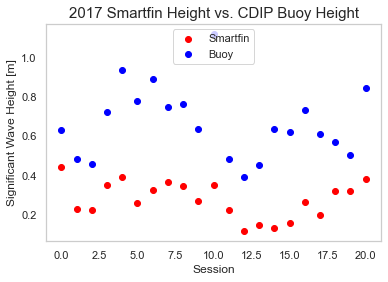

mean error is 57.9972639496802%
average difference is 0.39020056159618466 meters
average difference is 15.36223513009795 inches
length is 21


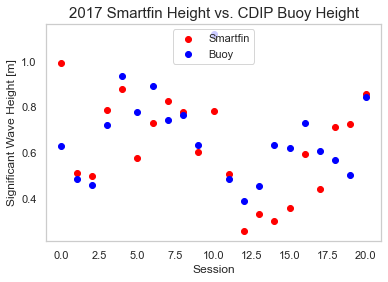

mean error is 27.02132835926465%
average difference is 0.13909679932412816 meters
average difference is 5.476254899070859 inches
length is 21


In [20]:
print(type(sig_heights))
fin = np.array(sig_heights)
print(type(fin))
buoy = np.array(CDIP_means)
fin3 = 2.25*fin
data_to_plot = pd.DataFrame({'Smartfin': fin,'Buoy': buoy, 'fin_converted': fin3, 'diff1': abs(buoy-fin), 'diff2': abs(buoy-fin3)})
# data_to_plot.drop(data_to_plot[data_to_plot['diff1'] > 1].index, inplace = True)
# data_to_plot.drop(data_to_plot[data_to_plot['diff2'] > .3].index, inplace = True)
# data_to_plot.drop(data_to_plot[data_to_plot['Smartfin'] > 1].index, inplace = False)
# data_to_plot.drop(data_to_plot[data_to_plot['Buoy'] > 1.3].index, inplace = True)

x = list(range(0, len(data_to_plot)))

#Original data plot
plt.scatter(x, data_to_plot['Smartfin'], color='red')
plt.scatter(x, data_to_plot['Buoy'], color='blue')
plt.legend(['Smartfin', 'Buoy'], loc=9)
plt.xlabel('Session')
plt.ylabel('Significant Wave Height [m]')
plt.title('2017 Smartfin Height vs. CDIP Buoy Height', size=15)
plt.grid()
plt.show()

error = (abs(data_to_plot['Buoy'] - data_to_plot['Smartfin']) / data_to_plot['Buoy']) * 100
error = np.mean(error)
avgdiff1 = data_to_plot['diff1'].mean()
print('mean error is ' + str(error) + '%')
print('average difference is ' + str(avgdiff1) + ' meters')
print('average difference is ' + str(avgdiff1*39.3701) + ' inches')
print('length is ' + str(len(data_to_plot)))

#Converted data plot
plt.scatter(x, data_to_plot['fin_converted'], color='red')
plt.scatter(x, data_to_plot['Buoy'], color='blue')
plt.legend(['Smartfin', 'Buoy'], loc=9)
plt.xlabel('Session')
plt.ylabel('Significant Wave Height [m]')
plt.title('2017 Smartfin Height vs. CDIP Buoy Height', size=15)
plt.grid()
plt.show()

error3 = abs((1 - (data_to_plot['Buoy']/data_to_plot['fin_converted'])) *100)
error3 = np.mean(error3)
avgdiff2 = data_to_plot['diff2'].mean()
print('mean error is ' + str(error3) + '%')
print('average difference is ' + str(data_to_plot['diff2'].mean()) + ' meters')
print('average difference is ' + str(avgdiff2*39.3701) + ' inches')
print('length is ' + str(len(data_to_plot)))

Linear Regression Model

In [ ]:
# (m,b) = np.polyfit(data_to_plot['Smartfin'],data_to_plot['Buoy'],1)
yp = np.polyval([m,b],data_to_plot['Smartfin'])
equation = 'y = ' + str(round(m,4)) + 'x' ' + ' + str(round(b,4))
plt.scatter(data_to_plot['Smartfin'],data_to_plot['Buoy'], color='red')
plt.plot(data_to_plot['Smartfin'],yp)
#plt.text(1,1, equation)

plt.xlabel('Smartfin Height [m]')
plt.ylabel('CDIP Buoy Height [m]')
plt.title('2017 Smartfin Height vs. CDIP Buoy Height', size=15)
plt.grid()
plt.show()
print('Prediction is: ' + str(equation))

#Calculate R^2 value
# x = fin
# y = buoy

correlation_matrix = np.corrcoef(data_to_plot['Smartfin'], data_to_plot['Buoy'])
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

print('R^2 value is: ' + str(r_squared))
print(len(data_to_plot))

In [ ]:
# TODO: figure out how to implement the water time cropper and also match the height analysis in the smartfin app with the one here